<a href="https://colab.research.google.com/github/yingzibu/MOL2ADMET/blob/main/examples/MLP/MLP_Morgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
print(torch.__version__)
print('cuda: ', torch.cuda.is_available())

2.1.0+cu121
cuda:  True


In [ ]:
! pip install rdkit --quiet
! pip install PyTDC --quiet
! pip install mycolorpy --quiet
! pip install selfies  --quiet
! pip install pubchempy --quiet
! pip install dgllife --quiet
! pip install molvs --quiet
! pip install dgl -f https://data.dgl.ai/wheels/cu121/repo.html --quiet
! pip install dglgo -f https://data.dgl.ai/wheels-test/repo.html --quiet
! pip install DeepPurpose --quiet
! pip install git+https://github.com/bp-kelley/descriptastorus --quiet
! pip install pandas-flavor --quiet

In [1]:
cd /content/drive/MyDrive/ADMET

/content/drive/MyDrive/ADMET


In [2]:
import pandas as pd
import torch
import os
from tqdm import tqdm
import numpy as np
from IPython.display import Code

In [12]:
def smile_list_to_MORGAN(smi_list:list, morgan_fp_len=2048):
    import rdkit
    from rdkit import Chem
    from tqdm import tqdm
    from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect as MorganFP
    MORGAN_list = []
    for smi in tqdm(smi_list, total=len(smi_list)):
        mol = m(smi)
        morgan = [float(i) for i in list(MorganFP(m(smi), useChirality=True,
                                            radius=2, nBits=morgan_fp_len))]

        MORGAN_list.append(morgan)
    return MORGAN_list

def process_Morgan(data_, header=[f'bit{i}' for i in range(2048)]):
    data = data_.copy()
    print('---> converting SMILES to Morgan FP...')
    l = smile_list_to_MORGAN(data['Drug'].tolist())
    len_here = len(l[0])
    assert len_here == len(header)
    data[header] = pd.DataFrame(l)
    print('---> FINISHED')

    return data

In [14]:
from scripts.CONSTANT import *
from scripts.preprocess_mols import *
from scripts.yaml_utils import *
from scripts.dataset import nn_dataset
name = names_M5[0]

trn, val, tst = collect_data(name)
dict_scale = None
scale_here = False
# trn, val, tst, dict_scale
con = get_config('MLP', name)

batch_size = con['batch_size']

p = {'batch_size': batch_size, 'shuffle': True,
     'drop_last': False, 'num_workers':0}
p_t = {'batch_size': batch_size, 'shuffle': False,
     'drop_last': False, 'num_workers':0}

trn_l = DataLoader(nn_dataset(trn, [name], process=process_Morgan, header=[f'bit{i}' for i in range(2048)]), **p)
val_l = DataLoader(nn_dataset(val, [name], process=process_Morgan, header=[f'bit{i}' for i in range(2048)]), **p)
tst_l = DataLoader(nn_dataset(tst, [name], process=process_Morgan, header=[f'bit{i}' for i in range(2048)]), **p_t)

Found local copy...
Loading...
Done!


collect data for:  ['CYP2C19_Veith']
---> converting SMILES to Morgan FP...


100%|██████████| 8866/8866 [00:12<00:00, 736.50it/s]


---> FINISHED
---> converting SMILES to Morgan FP...


100%|██████████| 1266/1266 [00:01<00:00, 753.29it/s]


---> FINISHED
---> converting SMILES to Morgan FP...


100%|██████████| 2533/2533 [00:03<00:00, 757.17it/s]


---> FINISHED


In [18]:
con['in_dim'] = 2048
con['hid_dims'] = [512, 218, 64, 4]

In [16]:
for i, j in trn_l:
    print(i.shape)
    break

torch.Size([128, 2048])


Model type:  MLP | Model parameters:  1175203
Start training MLP...
Epoch:0 [Train] Loss: 0.640 | [Valid] Loss: 0.568	SAVE MODEL: loss: inf -> 0.568 | runtime: 0.708 ms
Epoch:1 [Train] Loss: 0.534 | [Valid] Loss: 0.543	SAVE MODEL: loss: 0.568 -> 0.543 | runtime: 0.727 ms
Epoch:2 [Train] Loss: 0.498 | [Valid] Loss: 0.546	EarlyStopping counter: 1 out of 30
Epoch:3 [Train] Loss: 0.467 | [Valid] Loss: 0.555	EarlyStopping counter: 2 out of 30
Epoch:4 [Train] Loss: 0.445 | [Valid] Loss: 0.574	EarlyStopping counter: 3 out of 30
Epoch:5 [Train] Loss: 0.422 | [Valid] Loss: 0.610	EarlyStopping counter: 4 out of 30
Epoch:6 [Train] Loss: 0.401 | [Valid] Loss: 0.606	EarlyStopping counter: 5 out of 30
Epoch:7 [Train] Loss: 0.386 | [Valid] Loss: 0.648	EarlyStopping counter: 6 out of 30
Epoch:8 [Train] Loss: 0.374 | [Valid] Loss: 0.602	EarlyStopping counter: 7 out of 30
Epoch:9 [Train] Loss: 0.366 | [Valid] Loss: 0.664	EarlyStopping counter: 8 out of 30
Epoch:10 [Train] Loss: 0.354 | [Valid] Loss: 0.6

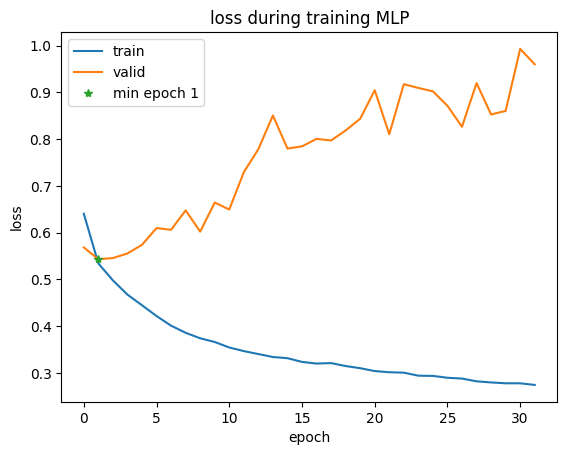

load pretrained model from  ckpt_MLP.pt
[Test] Loss: 0.539
*************** CYP2C19_Veith ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.791  &0.790  &0.774  &0.770  &0.809  &0.772 &0.844 &0.579 &0.756


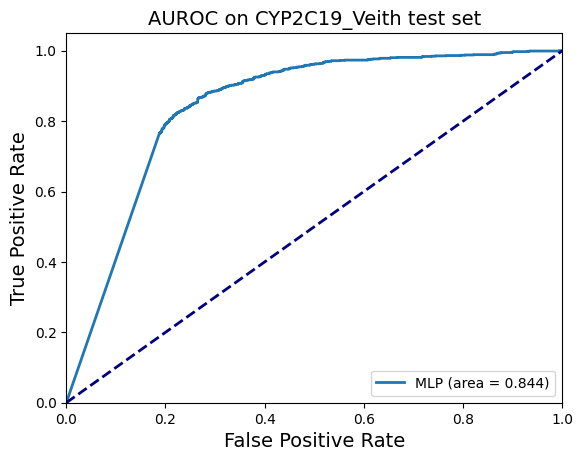

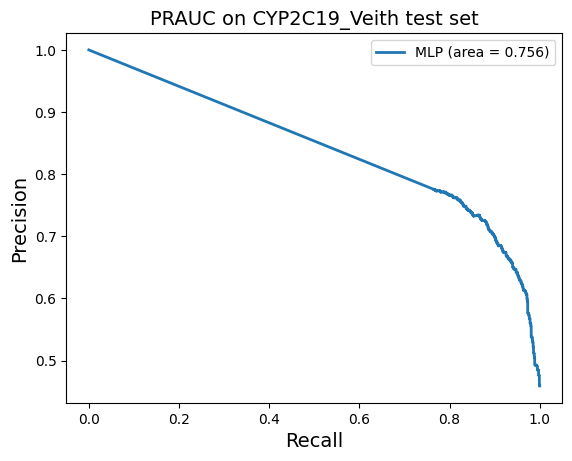



--> Train status saved at ckpt_MLP.yml
Finished evaluate test performance, outputs performance dict


In [26]:
models = PRED(**con)
p = models.train(trn_l, val_l, tst_l)

In [25]:
perfs = []
for i in range(10):
    p = yml_report(f'ST/{name}/MLP_ST_{i}.yml')
    perfs.append(p)

eval_perf_list(perfs, name, {})

repeated num # 10 idx 2 has the lowest loss
******************** CYP2C19_Veith ******************** 
	|       acc      |       w_acc      |       prec      |       recall      |       sp      |       f1      |       auc      |       mcc      |       ap      
	&0.778$\pm$0.004  &0.778$\pm$0.004  &0.747$\pm$0.013  &0.781$\pm$0.019  &0.775$\pm$0.020  &0.763$\pm$0.005  &0.852$\pm$0.003  &0.555$\pm$0.008  &0.808$\pm$0.003  
 idx 2: &0.785            &0.784            &0.761            &0.776            &0.793            &0.768            &0.854            &0.568            &0.805            



2

In [22]:
p = yml_report(f'ST/{name}/MLP_ST_{1}.yml')

In [23]:
p

{'CYP2C19_Veith': [0.7753651796288985,
  0.7756412750814343,
  0.7438423645320197,
  0.7790197764402408,
  0.7722627737226277,
  0.7610247795044098,
  0.849055111685736,
  0.5498419438794614,
  0.8030619101291273],
 'loss': 0.4881170243024826}